In [ ]:
# Install opencv for processing the image data
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os
import zipfile
import imutils
import gdown
import matplotlib.pyplot as plt

In [ ]:
# Download the Brain Tumor Image data as a zipped file
gdown.download('https://drive.google.com/uc?id=1snsNe9hpQPVEcwuH_G5tZMbqPRO6t5UA', 'BrainTumorDataset.zip', quiet=False)

# Unzip the zipped image data into a local folder
with zipfile.ZipFile('/content/BrainTumorDataset.zip', 'r') as zipped_file:
  zipped_file.extractall('/content/')

Downloading...
From: https://drive.google.com/uc?id=1snsNe9hpQPVEcwuH_G5tZMbqPRO6t5UA
To: /content/BrainTumorDataset.zip
100%|██████████| 156M/156M [00:02<00:00, 58.3MB/s]


In [ ]:
# Crop the given image to remove extraneous (marginal) pixels that contribute to noise in the image
# In more detail: preprocessing first includes cropping the image
# Extraneous pixels which are found after converting the image to grayscale,
# eroded, and dilated are removes. These pixels serve as noise for the dataset.
# In the image, they are numerous pixels which make up the black background of 
# the mri image. The majority of these pixels can be removed to improve accuracy.
def crop_image(image):
  # Convert to grayscale
  grayscale_image = cv2.GaussianBlur(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), (3, 3), 0)

  # Create a margin threshold for the image and erode/dilate it using the threshold
  image_threshold = cv2.threshold(grayscale_image, 45, 255, cv2.THRESH_BINARY)[1]
  eroded_image = cv2.erode(image_threshold, None, iterations=2)
  dilated_image = cv2.dilate(eroded_image, None, iterations=2)

  # Get the maximum contour of the dilated image (the area without the noise and primarily containing the mri scan)
  contours = imutils.grab_contours(cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))
  contour_array = max(contours, key=cv2.contourArea)

  # Set the pixel boundaries for the margins
  left_pixel= tuple(contour_array[contour_array[:, :, 0].argmin()][0])
  right_pixel = tuple(contour_array[contour_array[:, :, 0].argmax()][0])
  top_pixel = tuple(contour_array[contour_array[:, :, 1].argmin()][0])
  bottom_pixel = tuple(contour_array[contour_array[:, :, 1].argmax()][0])
  
  # Crop the image
  cropped_image = image[top_pixel[1]:bottom_pixel[1], left_pixel[0]:right_pixel[0]].copy()

  return cropped_image

In [ ]:
# Preprocess the images by cropping the images and resizing them
label_dict = {"glioma":  0, "meningioma": 1,  "notumor": 2, "pituitary": 3}
  
for folder in ['Training', 'Testing']:
  for label in label_dict:
    files = os.listdir('/content/'  + folder + '/' + label + '/')
    for img_file in files:
      im = cv2.imread('/content/'  + folder + '/' + label + '/' + img_file)
      im = crop_image(im)
      im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
      cv2.imwrite('/content/'  + folder + '/' + label + '/' + img_file, im)

In [ ]:
# Create a training dataset from the training folder for the BrainTumorDataset
# Use 5% of the training dataset as labeled training data
labeled_training_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/Training/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.95,
    subset='training')

# Use the remaining 95% as unlabeled training data
unlabeled_training_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/Training/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.95,
    subset='validation')
unlabeled_training_data = unlabeled_training_data.map(lambda image, label: image)

# Create a testing dataset from the testing folder for the BrainTumorDataset
testing_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/Testing/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=100)

Found 5712 files belonging to 4 classes.
Using 286 files for training.
Found 5712 files belonging to 4 classes.
Using 5426 files for validation.
Found 1311 files belonging to 4 classes.


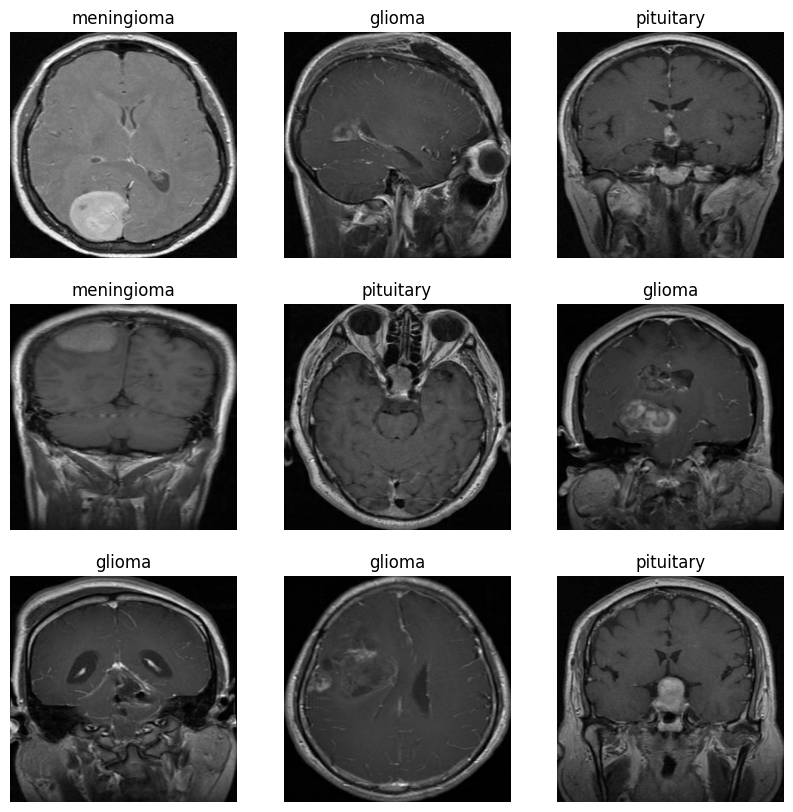

In [ ]:
# Show some images with their classes from the labeled training data
classes = labeled_training_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in labeled_training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

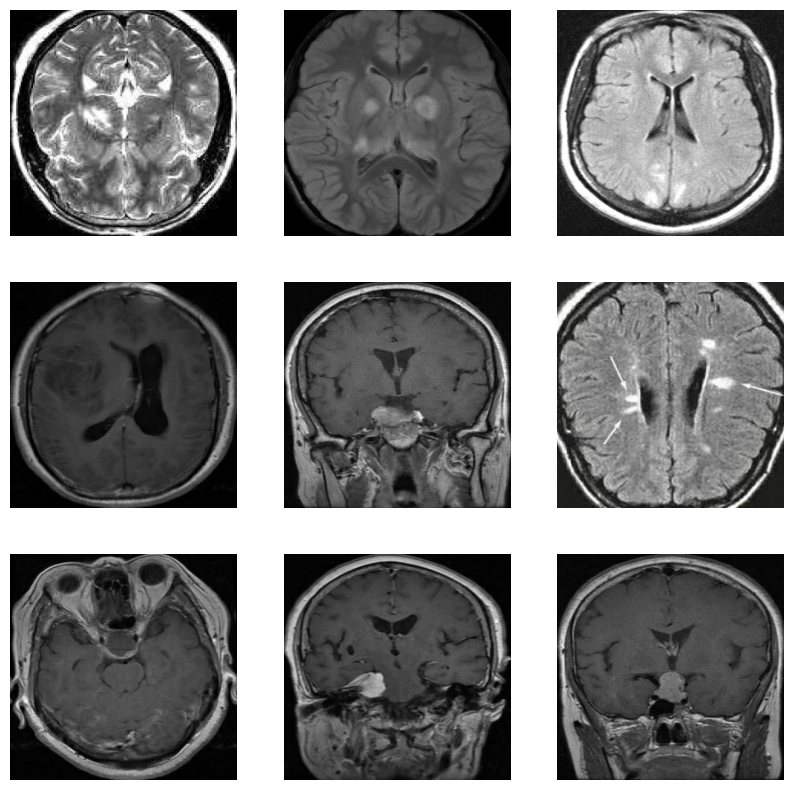

In [ ]:
# Show some images from the unlabeled training data
plt.figure(figsize=(10, 10))
for images in unlabeled_training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Zip the unlabeled and labeled datasets together
training_data = tf.data.Dataset.zip((unlabeled_training_data, labeled_training_data)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Image Augmentation module
# The area parameter determines whether the augmentation is weak (area of 0.75) or strong (area of 0.25)
# Augmentations are randomly flipping the image horizontally
# and shifting the image vertically and horizontally
def augmenter(area):
    strength = 1.0 - math.sqrt(area)
    return tf.keras.Sequential([tf.keras.Input(shape=(256, 256, 3)),
                                tf.keras.layers.Rescaling(1 / 255),
                                tf.keras.layers.RandomFlip('horizontal'),
                                tf.keras.layers.RandomTranslation(strength/2, strength/2)])
    
# Encoding module which will be used in the Contrastive Learning model
def encoder():
    return tf.keras.Sequential([tf.keras.Input(shape=(256, 256, 3)),
                                tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
                                tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
                                tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
                                tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(units=128, activation='relu')], name='Encoder')

In [ ]:
# Create the Contrastive Learning model
class CLModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = 0.1
        self.strongly_augmenter = augmenter(0.25)
        self.weakly_augmenter = augmenter(0.75)
        self.encoder = encoder()

        # Nonlinear projection head which might improve the encoder's representations quality
        self.projection_head = tf.keras.Sequential([tf.keras.Input(shape=(128,)),
                                                    tf.keras.layers.Dense(units=128, activation='relu'),
                                                    tf.keras.layers.Dense(units=128)], name='ProjectionHead')
        
        # Linear probing layer computed as the accuracy of a logistic regression classifier trained on top of the encoder's features
        self.linear_prober = tf.keras.Sequential([tf.keras.layers.Input(shape=(128,)), tf.keras.layers.Dense(10)], name="LinearProber")

        # Print the summaries of the encoder, projection head, and linear probe models
        self.encoder.summary()
        self.projection_head.summary()
        self.linear_prober.summary()

    def compile(self, contrastive_optimizer, linear_probe_optimizer, **kwargs):
        super().compile(**kwargs)

        # Assign optimizers for the 2 performance metrics
        self.contrastive_optimizer = contrastive_optimizer
        self.linear_probe_optimizer = linear_probe_optimizer

        # Compute the linear probing loss
        self.linear_probe_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        # Track and compute the accuracies using the performance metrics
        self.contrastive_loss_tracker = tf.keras.metrics.Mean(name='c_loss')
        self.contrastive_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='c_acc')
        self.linear_probe_loss_tracker = tf.keras.metrics.Mean(name='p_loss')
        self.linear_probe_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='p_acc')

    # Get the performance metrics
    @property
    def metrics(self):
        return [self.contrastive_loss_tracker, self.contrastive_accuracy, 
                self.linear_probe_loss_tracker, self.linear_probe_accuracy]

    # Compute the contrastive loss with the following:
    # InfoNCE loss (Information Noise-Contrastive Estimation)
    # NT-Xent loss (Normalized Temperature-Scaled Cross Entropy)
    def contrastive_loss(self, projections_1, projections_2):

        # Compute the cosine similarity matrix as the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarity_matrix = (tf.matmul(projections_1, projections_2, transpose_b=True)/self.temperature)

        # The similarity between representations of two augmentations of the
        # same image should be higher than their similarity with non augmentations
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarity_matrix)
        self.contrastive_accuracy.update_state(contrastive_labels, tf.transpose(similarity_matrix) )

        # Compute the Sparse Categorical Crossentropy loss using the temperature-scaled similarities
        loss_1_2 = tf.keras.losses.sparse_categorical_crossentropy(contrastive_labels, similarity_matrix, from_logits=True)
        loss_2_1 = tf.keras.losses.sparse_categorical_crossentropy(contrastive_labels, tf.transpose(similarity_matrix), from_logits=True)
        return (loss_1_2+loss_2_1)/2

    def train_step(self, data):
        (unlabeled_images), (labeled_images, labels) = data

        # Get the images without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)

        # Strongly Augment each image twice
        strongly_augmented_images_1 = self.strongly_augmenter(images, training=True)
        strongly_augmented_images_2 = self.strongly_augmenter(images, training=True)

        with tf.GradientTape() as tape:
            features_1 = self.encoder(strongly_augmented_images_1, training=True)
            features_2 = self.encoder(strongly_augmented_images_2, training=True)

            # Pass the representations through a projections MLP and calculate the contrastive loss
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        # Compute the gradients, apply them to the contrastive optimzer and update the loss
        gradients = tape.gradient(contrastive_loss, self.encoder.trainable_weights + self.projection_head.trainable_weights)
        self.contrastive_optimizer.apply_gradients(zip(gradients,self.encoder.trainable_weights + self.projection_head.trainable_weights))
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Weakly Augment each image
        weakly_augmented_images = self.weakly_augmenter(labeled_images, training=True)
        with tf.GradientTape() as tape:
            features = self.encoder(weakly_augmented_images , training=False)
            class_logits = self.linear_prober(features, training=True)
            linear_probe_loss = self.linear_probe_loss(labels, class_logits)
        gradients = tape.gradient(linear_probe_loss, self.linear_prober.trainable_weights)
        self.linear_probe_optimizer.apply_gradients(zip(gradients, self.linear_prober.trainable_weights))
        self.linear_probe_loss_tracker.update_state(linear_probe_loss)
        self.linear_probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # Weakly augment the image during the test step
        weakly_augmented_images = self.weakly_augmenter(labeled_images, training=False)
        features = self.encoder(weakly_augmented_images, training=False)
        class_logits = self.linear_prober(features, training=False)
        linear_probe_loss = self.linear_probe_loss(labels, class_logits)
        self.linear_probe_loss_tracker.update_state(linear_probe_loss)
        self.linear_probe_accuracy.update_state(labels, class_logits)

        # Log the Linear probe performance metric
        return {m.name: m.result() for m in self.metrics[2:]}

In [ ]:
# Train an initial model using Contrastive Learning and Semi-Supervised Learning
initial_model = CLModel()
initial_model.compile(contrastive_optimizer=tf.keras.optimizers.Adam(), linear_probe_optimizer=tf.keras.optimizers.Adam())

# Get the results of training the initial model using the test data as the validation set
initial_results = initial_model.fit(training_data, epochs=20, validation_data=testing_data)

# Print the best validation accuracy which is essentially the testing accuracy
print("Maximal Testing accuracy: {:.2f}%".format(max(initial_results.history["val_p_acc"]) * 100))

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 127, 127, 128)     3584      
                                                                 
 conv2d_53 (Conv2D)          (None, 63, 63, 128)       147584    
                                                                 
 conv2d_54 (Conv2D)          (None, 31, 31, 128)       147584    
                                                                 
 conv2d_55 (Conv2D)          (None, 15, 15, 128)       147584    
                                                                 
 flatten_13 (Flatten)        (None, 28800)             0         
                                                                 
 dense_44 (Dense)            (None, 128)               3686528   
                                                                 
Total params: 4,132,864
Trainable params: 4,132,864
Non-tra

In [ ]:
# Supervised finetuning of the pretrained encoder
finetuned_model = tf.keras.Sequential([tf.keras.layers.Input(shape=(256, 256, 3)),
                                       augmenter(0.75),
                                       initial_model.encoder,
                                       tf.keras.layers.Dense(10)],name="finetuning_model")
finetunned_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")])

# Get the results of training the finetuned model using the test data as the validation set
finetuning_history = finetuned_model.fit(labeled_training_data, epochs=20, validation_data=testing_data)

# Print the best validation accuracy which is essentially the testing accuracy
print("Maximal testing accuracy: {:.2f}%".format(max(finetuning_history.history["val_acc"]) * 100))

Epoch 1/20
9/9 [==============================] - 121s 14s/step - loss: 2.9629 - acc: 0.2902 - val_loss: 1.4318 - val_acc: 0.4447
Epoch 2/20
9/9 [==============================] - 118s 14s/step - loss: 1.2258 - acc: 0.5175 - val_loss: 1.2063 - val_acc: 0.5210
Epoch 3/20
9/9 [==============================] - 84s 10s/step - loss: 1.1064 - acc: 0.5385 - val_loss: 1.1766 - val_acc: 0.4828
Epoch 4/20
9/9 [==============================] - 118s 14s/step - loss: 1.0237 - acc: 0.5804 - val_loss: 1.0219 - val_acc: 0.5500
Epoch 5/20
9/9 [==============================] - 117s 14s/step - loss: 0.8925 - acc: 0.6538 - val_loss: 1.1765 - val_acc: 0.5355
Epoch 6/20
9/9 [==============================] - 116s 14s/step - loss: 0.8118 - acc: 0.6783 - val_loss: 0.9748 - val_acc: 0.6522
Epoch 7/20
9/9 [==============================] - 118s 14s/step - loss: 0.7303 - acc: 0.7308 - val_loss: 1.1881 - val_acc: 0.6278
Epoch 8/20
9/9 [==============================] - 118s 14s/step - loss: 0.6968 - acc: 0.706